# Prediction of change of admission for heart disease

In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder  
from sklearn import preprocessing 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
torch.manual_seed(0)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
hidden_size = 32
num_epochs = 7800
batch_size = 50 
learning_rate = 1e-3

# load data from csv. Make sure the location of the file is correct
csv_file = './heart.csv'
original_df = pd.read_csv(csv_file)  
#label_encoder
label_encoder = preprocessing.LabelEncoder()  
original_df['Sex']= label_encoder.fit_transform(original_df['Sex'])#'ChestPainType','RestingECG','ExerciseAngina','ST_Slope'])  
original_df['Sex'].unique()  
original_df['ChestPainType']= label_encoder.fit_transform(original_df['ChestPainType']) 
original_df['ChestPainType'].unique()   
original_df['RestingECG']= label_encoder.fit_transform(original_df['RestingECG']) 
original_df['RestingECG'].unique()  
original_df['ExerciseAngina']= label_encoder.fit_transform(original_df['ExerciseAngina']) 
original_df['ExerciseAngina'].unique()  
original_df['ST_Slope']= label_encoder.fit_transform(original_df['ST_Slope']) 
original_df['ST_Slope'].unique()   
labeled_df=original_df[['Sex', 'ChestPainType','RestingECG','ExerciseAngina','ST_Slope']]  
original_df_numbers=original_df.drop(columns= ["Sex",'ChestPainType','RestingECG','ExerciseAngina',"ST_Slope"])
df = pd.concat([original_df_numbers,labeled_df],axis=1) 
#reorder the columns properly 
age_col= df.pop('Age')
df.insert(0,'Age',age_col)#(index,column title,Variable name) 
RestingBP_col= df.pop('RestingBP') 
df.insert(3,'RestingBP',RestingBP_col)  
Sex_col= df.pop('Sex') 
df.insert(1,'Sex',Sex_col)  
ChestPainType_col= df.pop('ChestPainType') 
df.insert(2,'ChestPainType',ChestPainType_col)  
Cholesterol_col= df.pop('Cholesterol') 
df.insert(4,'Cholesterol',Cholesterol_col)  
FastingBS_col= df.pop('FastingBS') 
df.insert(5,'FastingBS',FastingBS_col)   
RestingECG_col= df.pop('RestingECG') 
df.insert(6,'RestingECG',RestingECG_col)   
MaxHR_col= df.pop('MaxHR') 
df.insert(7,'MaxHR',MaxHR_col)   
ExerciseAngina_col= df.pop('ExerciseAngina') 
df.insert(8,'ExerciseAngina',ExerciseAngina_col)   
Oldpeak_col= df.pop('Oldpeak') 
df.insert(9,'Oldpeak',Oldpeak_col)   
ST_Slope_col= df.pop('ST_Slope') 
df.insert(10,'ST_Slope',ST_Slope_col)   
HeartDisease_col= df.pop('HeartDisease') 
df.insert(11,'HeartDisease',HeartDisease_col)  
df=df.to_numpy()

In [16]:
original_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


# Define Datasets

In [2]:
# define features as X, and label as y. y is the change of admit, X includes GRE, TOFEL,..., research paper.
X_df, y_df = df[:, :-1], df[:, -1]

# split dataset into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=10)

# change numpy arrays to tensors
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor)

# define pytorch datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define your model

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        self.fc = nn.Linear(input_size, 1)        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1) 
         
# define your model
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x) 
      
        return x
 

input_size = 11
hidden_size=32
network = Model(input_size=input_size, hidden_size=hidden_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate) 
#add layers to the model 

# Train Model

In [4]:
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_loader):
        # Move tensors to the configured device
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = network(X)
        loss = criterion(y_pred.squeeze(), y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if (i+1) % 1 == 0:
            #print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test Model

In [5]:
for i, (X, y) in enumerate(test_loader):
    # Move tensors to the configured device
    X = X.to(device)
    y = y.to(device)

    # Forward pass
    with torch.no_grad():
        y_pred = network(X)
        loss = criterion(y_pred.squeeze(), y)

    print(f'Test loss: {loss.item():.4f}')

#why are there mulitple test losses? 
#Steps represent the random state

Test loss: 0.1417
Test loss: 0.1761
Test loss: 0.1099
Test loss: 0.0698


# Show Results

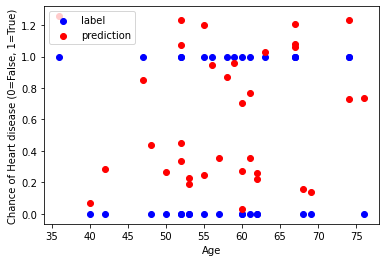

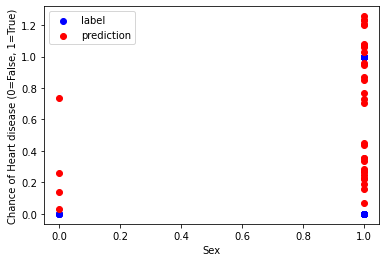

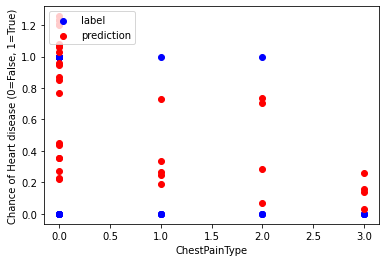

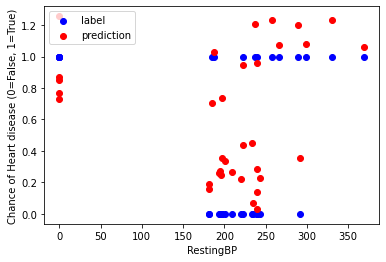

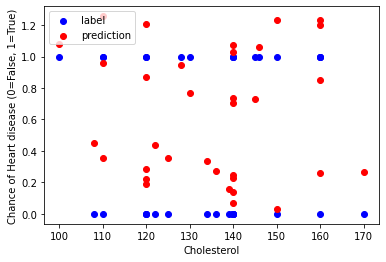

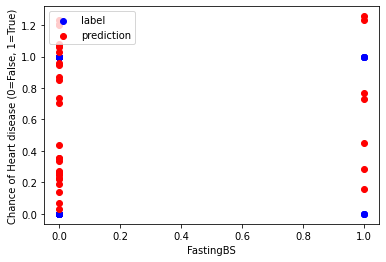

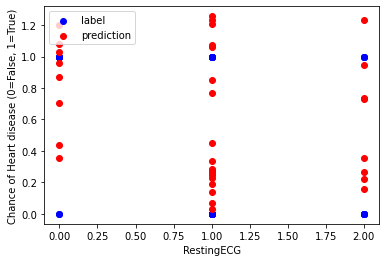

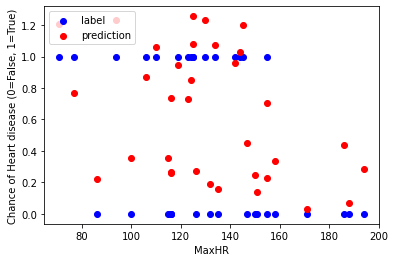

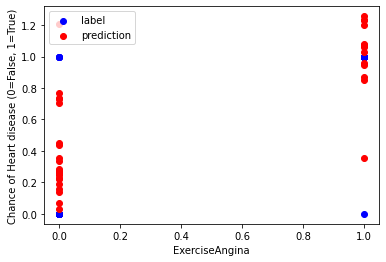

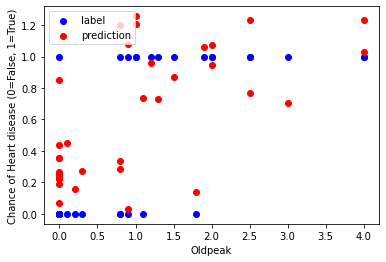

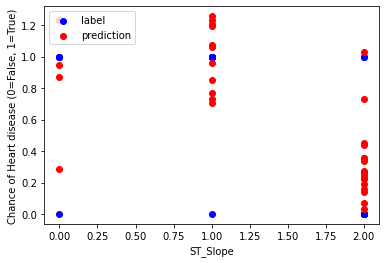

In [6]:
label_name=['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope']

for ind in range(len(label_name)):
    feature_num=ind

    plt.scatter(X[:,ind], y, c='b', label='label')
    plt.scatter(X[:,ind], y_pred, c='r', label='prediction')
        
    plt.xlabel(label_name[ind])
    plt.ylabel('Chance of Heart disease (0=False, 1=True)')
    plt.legend(loc="upper left")
    plt.show()
    

# What Was Found

1. The model found that people after 65 are at a much higher risk for heart disease than younger patients and Men are at much higher risk than women. 
2. There are 4 different types of chest pain: ASY, NAP, ATA and TA. ASY is represented as 0 on the X axis, ATA is represented as 1, NAP is represented as 2, and TA is represented as 3. ASY is a type of chest pain that is caused when there is no electrcity in the heart, NAP chest pain is located in the middle of the chest, ATA is atrial tachyarrhythmias which is also known as an arrhythmia. TA stands for typical angina which is substernal chest pain precipitated by physical exertion or emotional stress and relieved with rest or nitroglycerin. People with ASY have a much higher chance of having heart disease than any other type of chest pain. TA has the lowest rate of heart disease. 
3. People with extremely low RestingBP and people with a restingBP over 250 are the most likely demograpics to have heart disease. 
4. The dataset had 3 different types of resting ECG: Normal, ST, and LVH. 0 represents LVH, 1 represents normal, and 2 represents ST on the graph. An ECG is short for electrocardiogram and it tests how fast the heart is beating, the rhythm of the heart beats, and the strength and timing of the electrical impulses as they move through the different parts of the heart. The ST segment encompasses the region between the end of ventricular depolarization and beginning of ventricular repolarization on the ECG and the LVH means that the test shows that a patient has left ventricle hypertrophy. The vast majority of the patients has normal ECGs  and concerns found in the ST segment of the test were far more correlated with heart disease than an LVH issue. 
5. A lower maximum heart rate was shown to be correlated with heart disease and exercise Angina was highly correlated with heart disease.  
6. Oldpeak is ST depression caused by activity in comparison to rest. The higher Oldpeak was proven to be correlated with heart disease being present. 
7. The ST slope can either be up, down, or flat. The ST slope shows us a shift relative to exercise-induced increments in heart rate. On the graph, 2 represents an upward ST slope, 1 represent s a flat ST slope, and 0 represents a downward ST slope. Having a flat ST slope is highly correlated with having heart disese and having an upward ST slope is highly correlated with having good heart health. 

# Redefining the model with theReLU

In [7]:
# Hyper-parameters for ReLU
hidden_size = 32
num_epochs = 2700
batch_size =  20
learning_rate = 1e-3

In [8]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.fc3 = nn.Linear(hidden_size, 1) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  
        x = self.relu(x)  
        x = self.fc3(x)   
        
        return x

input_size = 11  
hidden_size = 32  

network = Model(input_size=input_size, hidden_size=hidden_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
#add layers to the model

In [9]:
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_loader):
        # Move tensors to the configured device
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = network(X)
        loss = criterion(y_pred.squeeze(), y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if (i+1) % 1 == 0:
            #print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test Neural Network

In [10]:
for i, (X, y) in enumerate(test_loader):
    # Move tensors to the configured device
    X = X.to(device)
    y = y.to(device)

    # Forward pass
    with torch.no_grad():
        y_pred = network(X)
        loss = criterion(y_pred.squeeze(), y)

    print(f'Test loss: {loss.item():.4f}')


Test loss: 0.1856
Test loss: 0.2873
Test loss: 0.1705
Test loss: 0.0698


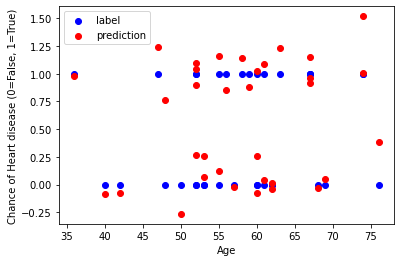

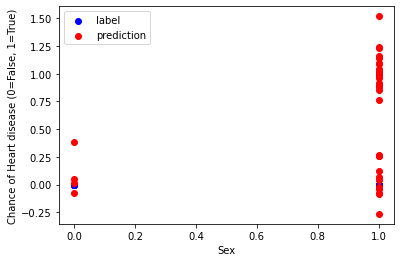

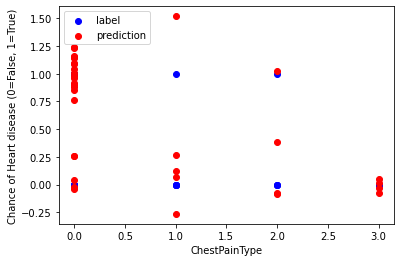

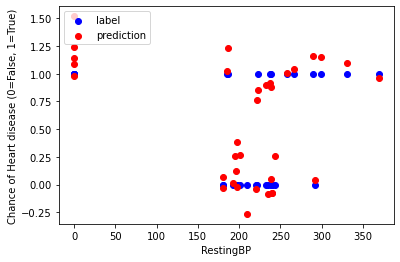

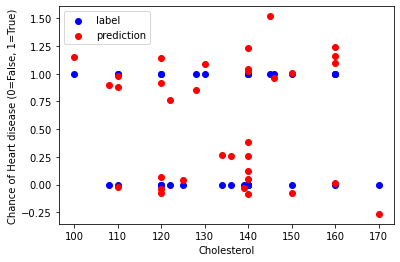

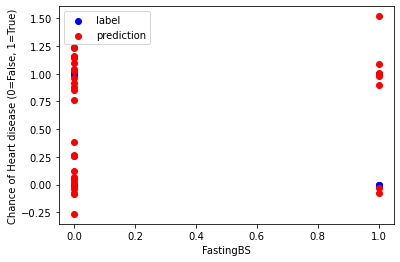

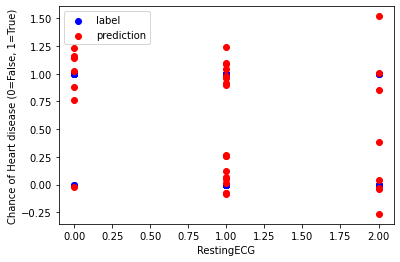

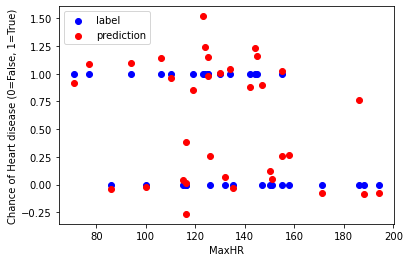

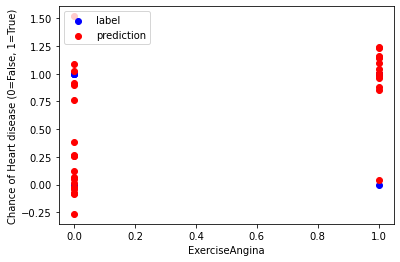

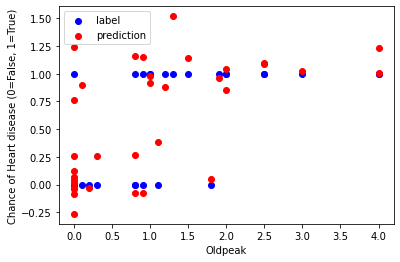

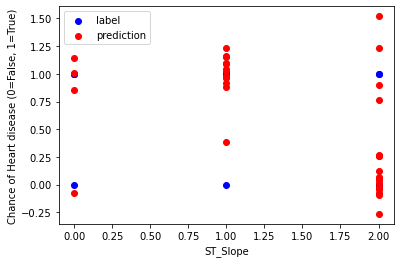

In [11]:
label_name=['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope']
for ind in range(len(label_name)):
    feature_num=ind

    plt.scatter(X[:,ind], y, c='b', label='label')
    plt.scatter(X[:,ind], y_pred, c='r', label='prediction')
        
    plt.xlabel(label_name[ind])
    plt.ylabel('Chance of Heart disease (0=False, 1=True)')
    plt.legend(loc="upper left")
    plt.show()
    

# What Was Found

1. The model found that people after 65 are at a slighty higher risk for heart disease than younger patients and Men are at much higher risk than women. 
2. There are 4 different types of chest pain: ASY, NAP, ATA and TA. ASY is represented as 0 on the X axis, ATA is represented as 1, NAP is represented as 2, and TA is represented as 3. ASY is a type of chest pain that is caused when there is no electrcity in the heart, NAP chest pain is located in the middle of the chest, ATA is atrial tachyarrhythmias which is also known as an arrhythmia. TA stands for typical angina which is substernal chest pain precipitated by physical exertion or emotional stress and relieved with rest or nitroglycerin. People with ASY have a much higher chance of having heart disease than any other type of chest pain by a lot. TA has the lowest rate of heart disease. 
3. People a restingBP between 150 and 250 had the healthiest hearts. Being outside of that range has a correlation for testing positive for heart disease. 
4. The dataset had 3 different types of resting ECG: Normal, ST, and LVH. 0 represents LVH, 1 represents normal, and 2 represents ST on the graph. An ECG is short for electrocardiogram and it tests how fast the heart is beating, the rhythm of the heart beats, and the strength and timing of the electrical impulses as they move through the different parts of the heart. The ST segment encompasses the region between the end of ventricular depolarization and beginning of ventricular repolarization on the ECG and the LVH means that the test shows that a patient has left ventricle hypertrophy. It was found that patients who did not have normal ECG tests are at higher risk for heart disease. 
5. Patients who had a max heart rate of at least 150 were proven to be healthier than their counterparts. 
6. Oldpeak is ST depression caused by activity in comparison to rest. The higher Oldpeak was proven to be correlated with heart disease being present. 
7. The ST slope can either be up, down, or flat. The ST slope shows us a shift relative to exercise-induced increments in heart rate. On the graph, 2 represents an upward ST slope, 1 represent s a flat ST slope, and 0 represents a downward ST slope. Having a flat ST slope is highly correlated with having heart disese and having an upward ST slope is highly correlated with having good heart health. 

# How the Models Compare

Both models have very similar accuracy rates and presented nearly identical results despite requiring different hyper paramaerters to run at optimal accuracy.